In [1]:
import torch
from data import MarineDebrisDataset
from transforms import augment
import pytorch_lightning

In [2]:
from train_marinedetector import ResNetClassifier

In [4]:
!ls .

callbacks.py  last-v3.ckpt    __pycache__	       transforms.py
data	      lightning_logs  requirements.txt	       visualization.py
eval.ipynb    loss.py	      train_marinedetector.py
last.ckpt     model	      train.py


In [5]:
import pytorch_lightning as pl
ds = MarineDebrisDataset(root="/ssd/marinedebris/marinedebris_refined", fold="train", shuffle=False,
                         imagesize=1280, transform=None)

model = ResNetClassifier.load_from_checkpoint("last.ckpt")
train_loader = torch.utils.data.DataLoader(ds, batch_size=128, num_workers=0, drop_last=True)

In [6]:
from tqdm.notebook import tqdm
from torch import nn

criterion = nn.BCEWithLogitsLoss()
model.eval()

i = 0
with torch.no_grad():
    logits, y_trues = [], []
    for x, y in tqdm(train_loader, total=len(train_loader)):
        y_hat = model(x)
        logits.append(y_hat)
        y_trues.append(y)
        loss = criterion(y_hat.squeeze(), y.float())
        print(loss)
        i+=1
        if i>5:
            break

  0%|          | 0/19 [00:00<?, ?it/s]

tensor(6.2313)
tensor(5.9684)
tensor(3.3513)
tensor(0.0005)
tensor(0.0009)
tensor(0.3626)


In [7]:
y_pred = torch.hstack(logits) > 0
y_true = torch.hstack(y_trues)

In [8]:
(y_pred == y_true).float().mean()

tensor(0.5430)

In [9]:
model(x)

tensor([-6.4689e+00, -6.6906e+00, -6.7234e+00, -6.3764e+00, -5.8698e+00,
        -6.1039e+00, -6.0879e+00, -5.8734e+00, -6.1069e+00, -6.2363e+00,
        -6.1209e+00, -5.9912e+00, -5.8964e+00, -6.1312e+00, -6.1752e+00,
        -6.1853e+00, -6.8047e+00, -6.0608e+00, -6.2689e+00, -6.0169e+00,
        -5.9979e+00, -6.0176e+00, -5.9619e+00, -5.9185e+00, -5.6720e+00,
        -4.5948e+00, -6.1924e+00, -6.1406e+00, -4.6518e+00, -4.9952e+00,
        -6.2346e+00, -6.0618e+00, -4.8035e+00, -5.2510e+00,  3.8285e+00,
         4.5563e+00,  4.4544e+00,  4.5334e+00,  4.3341e-01,  3.2314e+00,
        -8.0025e-01, -9.4885e-01,  6.4717e-02, -2.6372e+00,  1.6403e+00,
         1.8033e+00,  2.2440e+00,  8.1312e+00,  7.4946e+00,  8.9938e+00,
         8.9815e+00,  7.3097e+00,  8.7145e+00,  8.4244e+00,  7.6547e+00,
         6.2839e+00,  1.8278e+00,  2.6853e+00,  1.7202e+00,  4.0698e+00,
         3.0344e+00,  8.8879e-01,  3.7409e+00,  1.3941e-01, -2.2496e+00,
         5.8138e+00,  5.8197e+00,  3.9806e+00,  4.5

In [10]:

class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers, reshape_transform):
        self.model = model
        self.gradients = []
        self.activations = []
        self.reshape_transform = reshape_transform
        self.handles = []
        for target_layer in target_layers:
            self.handles.append(
                target_layer.register_forward_hook(self.save_activation))
            # Because of https://github.com/pytorch/pytorch/issues/61519,
            # we don't use backward hook to record gradients.
            self.handles.append(
                target_layer.register_forward_hook(self.save_gradient))

    def save_activation(self, module, input, output):
        activation = output

        if self.reshape_transform is not None:
            activation = self.reshape_transform(activation)
        self.activations.append(activation.cpu().detach())

    def save_gradient(self, module, input, output):
        if not hasattr(output, "requires_grad") or not output.requires_grad:
            # You can only register hooks on tensor requires grad.
            return

        # Gradients are computed in reverse order
        def _store_grad(grad):
            if self.reshape_transform is not None:
                grad = self.reshape_transform(grad)
            self.gradients = [grad.cpu().detach()] + self.gradients

        output.register_hook(_store_grad)

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        return self.model(x)

    def release(self):
        for handle in self.handles:
            handle.remove()


1


/tmp/ipykernel_3569/3274825384.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images, labels = torch.tensor(x).unsqueeze(0), torch.tensor(y).unsqueeze(0)


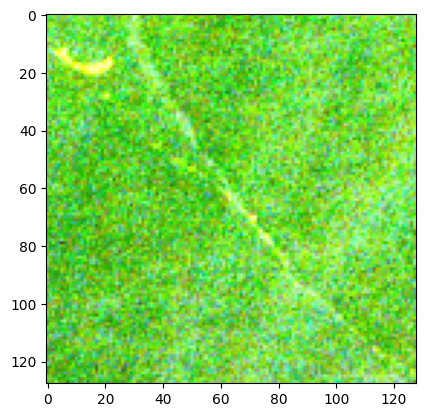

In [11]:
import matplotlib.pyplot as plt

x,y = ds[100]
from skimage.exposure import equalize_hist

print(y)

import numpy as np
plt.imshow(equalize_hist(x[np.array([3,2,1])].numpy()).transpose(1,2,0))


images, labels = torch.tensor(x).unsqueeze(0), torch.tensor(y).unsqueeze(0)


act = ActivationsAndGradients(model, [model.model.layer1[-1]], reshape_transform=lambda x: x)
logits = act(images)

(logits).backward()
labels = torch.ones_like(labels)

#loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, labels.float())
#loss.backward()

alpha = act.gradients[0].mean(-1).mean(-1)

A = act.activations[0].permute(0,2,3,1)

gradcam = (alpha[0] * A[0]).sum(-1)

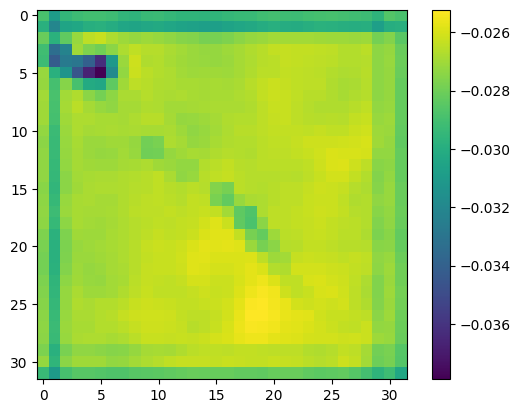

In [12]:
import matplotlib.pyplot as plt
plt.imshow(gradcam)
plt.colorbar()

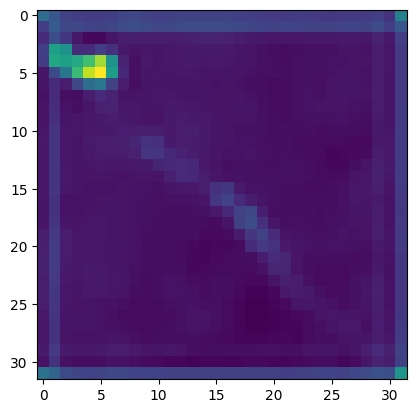

In [13]:
plt.imshow(A.mean(-1)[0])

In [14]:
model(x.unsqueeze(0))

tensor([-4.8667], grad_fn=<SqueezeBackward1>)

tensor([1]) 1


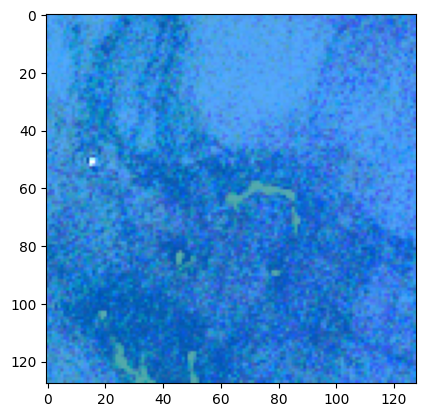

In [15]:
x,y = ds[1500]
y_pred = (model(x.unsqueeze(0)) > 0).long()
print(y_pred, y)

plt.imshow(equalize_hist(x[np.array([3,2,1])].numpy()).transpose(1,2,0))

In [16]:
m

NameError: name 'm' is not defined

In [37]:
from tqdm.auto import tqdm
device = "cuda"
lamb=1e-6
x = x.cpu()
model = ResNetClassifier.load_from_checkpoint("last.ckpt")

m = nn.Parameter(torch.rand(128,128) * 0.1 + 1)
optimizer = torch.optim.SGD([m], lr=0.1)

mode="preserve"
#mode = "delete"
for _ in tqdm(range(2000)):
    optimizer.zero_grad()

    m_ = torch.sigmoid(m.unsqueeze(0).repeat(x.shape[0],1,1))
    
    e = x * m_
    logits_e = model(e.unsqueeze(0))

    regularization = torch.linalg.norm(m.view(-1), 1) #m.mean() # torch.linalg.norm(m, 1)
    if mode == "preserve":
        xeloss = torch.nn.functional.binary_cross_entropy_with_logits(logits_e,torch.ones_like(logits_e))
        loss = xeloss + lamb * regularization
    elif mode == "delete":
        negprob = -torch.sigmoid(logits_e)
        loss = -(negprob + lamb * regularization)
    
    loss.backward()
    optimizer.step()
    print(loss)


  0%|          | 0/2000 [00:00<?, ?it/s]

tensor(0.0489, grad_fn=<AddBackward0>)
tensor(0.0489, grad_fn=<AddBackward0>)
tensor(0.0488, grad_fn=<AddBackward0>)
tensor(0.0488, grad_fn=<AddBackward0>)
tensor(0.0487, grad_fn=<AddBackward0>)
tensor(0.0487, grad_fn=<AddBackward0>)
tensor(0.0486, grad_fn=<AddBackward0>)
tensor(0.0486, grad_fn=<AddBackward0>)
tensor(0.0485, grad_fn=<AddBackward0>)
tensor(0.0485, grad_fn=<AddBackward0>)
tensor(0.0484, grad_fn=<AddBackward0>)
tensor(0.0484, grad_fn=<AddBackward0>)
tensor(0.0484, grad_fn=<AddBackward0>)
tensor(0.0483, grad_fn=<AddBackward0>)
tensor(0.0483, grad_fn=<AddBackward0>)
tensor(0.0482, grad_fn=<AddBackward0>)
tensor(0.0482, grad_fn=<AddBackward0>)
tensor(0.0481, grad_fn=<AddBackward0>)
tensor(0.0481, grad_fn=<AddBackward0>)
tensor(0.0480, grad_fn=<AddBackward0>)
tensor(0.0480, grad_fn=<AddBackward0>)
tensor(0.0479, grad_fn=<AddBackward0>)
tensor(0.0479, grad_fn=<AddBackward0>)
tensor(0.0478, grad_fn=<AddBackward0>)
tensor(0.0478, grad_fn=<AddBackward0>)
tensor(0.0478, grad_fn=<A

tensor(0.0408, grad_fn=<AddBackward0>)
tensor(0.0408, grad_fn=<AddBackward0>)
tensor(0.0407, grad_fn=<AddBackward0>)
tensor(0.0407, grad_fn=<AddBackward0>)
tensor(0.0407, grad_fn=<AddBackward0>)
tensor(0.0406, grad_fn=<AddBackward0>)
tensor(0.0406, grad_fn=<AddBackward0>)
tensor(0.0406, grad_fn=<AddBackward0>)
tensor(0.0406, grad_fn=<AddBackward0>)
tensor(0.0405, grad_fn=<AddBackward0>)
tensor(0.0405, grad_fn=<AddBackward0>)
tensor(0.0405, grad_fn=<AddBackward0>)
tensor(0.0404, grad_fn=<AddBackward0>)
tensor(0.0404, grad_fn=<AddBackward0>)
tensor(0.0404, grad_fn=<AddBackward0>)
tensor(0.0404, grad_fn=<AddBackward0>)
tensor(0.0403, grad_fn=<AddBackward0>)
tensor(0.0403, grad_fn=<AddBackward0>)
tensor(0.0403, grad_fn=<AddBackward0>)
tensor(0.0402, grad_fn=<AddBackward0>)
tensor(0.0402, grad_fn=<AddBackward0>)
tensor(0.0402, grad_fn=<AddBackward0>)
tensor(0.0401, grad_fn=<AddBackward0>)
tensor(0.0401, grad_fn=<AddBackward0>)
tensor(0.0401, grad_fn=<AddBackward0>)
tensor(0.0401, grad_fn=<A

tensor(0.0354, grad_fn=<AddBackward0>)
tensor(0.0354, grad_fn=<AddBackward0>)
tensor(0.0354, grad_fn=<AddBackward0>)
tensor(0.0354, grad_fn=<AddBackward0>)
tensor(0.0353, grad_fn=<AddBackward0>)
tensor(0.0353, grad_fn=<AddBackward0>)
tensor(0.0353, grad_fn=<AddBackward0>)
tensor(0.0353, grad_fn=<AddBackward0>)
tensor(0.0353, grad_fn=<AddBackward0>)
tensor(0.0352, grad_fn=<AddBackward0>)
tensor(0.0352, grad_fn=<AddBackward0>)
tensor(0.0352, grad_fn=<AddBackward0>)
tensor(0.0352, grad_fn=<AddBackward0>)
tensor(0.0352, grad_fn=<AddBackward0>)
tensor(0.0351, grad_fn=<AddBackward0>)
tensor(0.0351, grad_fn=<AddBackward0>)
tensor(0.0351, grad_fn=<AddBackward0>)
tensor(0.0351, grad_fn=<AddBackward0>)
tensor(0.0351, grad_fn=<AddBackward0>)
tensor(0.0350, grad_fn=<AddBackward0>)
tensor(0.0350, grad_fn=<AddBackward0>)
tensor(0.0350, grad_fn=<AddBackward0>)
tensor(0.0350, grad_fn=<AddBackward0>)
tensor(0.0350, grad_fn=<AddBackward0>)
tensor(0.0349, grad_fn=<AddBackward0>)
tensor(0.0349, grad_fn=<A

tensor(0.0320, grad_fn=<AddBackward0>)
tensor(0.0320, grad_fn=<AddBackward0>)
tensor(0.0320, grad_fn=<AddBackward0>)
tensor(0.0320, grad_fn=<AddBackward0>)
tensor(0.0320, grad_fn=<AddBackward0>)
tensor(0.0320, grad_fn=<AddBackward0>)
tensor(0.0319, grad_fn=<AddBackward0>)
tensor(0.0319, grad_fn=<AddBackward0>)
tensor(0.0319, grad_fn=<AddBackward0>)
tensor(0.0319, grad_fn=<AddBackward0>)
tensor(0.0319, grad_fn=<AddBackward0>)
tensor(0.0319, grad_fn=<AddBackward0>)
tensor(0.0319, grad_fn=<AddBackward0>)
tensor(0.0319, grad_fn=<AddBackward0>)
tensor(0.0318, grad_fn=<AddBackward0>)
tensor(0.0318, grad_fn=<AddBackward0>)
tensor(0.0318, grad_fn=<AddBackward0>)
tensor(0.0318, grad_fn=<AddBackward0>)
tensor(0.0318, grad_fn=<AddBackward0>)
tensor(0.0318, grad_fn=<AddBackward0>)
tensor(0.0318, grad_fn=<AddBackward0>)
tensor(0.0318, grad_fn=<AddBackward0>)
tensor(0.0318, grad_fn=<AddBackward0>)
tensor(0.0317, grad_fn=<AddBackward0>)
tensor(0.0317, grad_fn=<AddBackward0>)
tensor(0.0317, grad_fn=<A

tensor(0.0299, grad_fn=<AddBackward0>)
tensor(0.0299, grad_fn=<AddBackward0>)
tensor(0.0299, grad_fn=<AddBackward0>)
tensor(0.0299, grad_fn=<AddBackward0>)
tensor(0.0298, grad_fn=<AddBackward0>)
tensor(0.0298, grad_fn=<AddBackward0>)
tensor(0.0298, grad_fn=<AddBackward0>)
tensor(0.0298, grad_fn=<AddBackward0>)
tensor(0.0298, grad_fn=<AddBackward0>)
tensor(0.0298, grad_fn=<AddBackward0>)
tensor(0.0298, grad_fn=<AddBackward0>)
tensor(0.0298, grad_fn=<AddBackward0>)
tensor(0.0298, grad_fn=<AddBackward0>)
tensor(0.0298, grad_fn=<AddBackward0>)
tensor(0.0298, grad_fn=<AddBackward0>)
tensor(0.0298, grad_fn=<AddBackward0>)
tensor(0.0298, grad_fn=<AddBackward0>)
tensor(0.0298, grad_fn=<AddBackward0>)
tensor(0.0297, grad_fn=<AddBackward0>)
tensor(0.0297, grad_fn=<AddBackward0>)
tensor(0.0297, grad_fn=<AddBackward0>)
tensor(0.0297, grad_fn=<AddBackward0>)
tensor(0.0297, grad_fn=<AddBackward0>)
tensor(0.0297, grad_fn=<AddBackward0>)
tensor(0.0297, grad_fn=<AddBackward0>)
tensor(0.0297, grad_fn=<A

tensor(0.0286, grad_fn=<AddBackward0>)
tensor(0.0286, grad_fn=<AddBackward0>)
tensor(0.0285, grad_fn=<AddBackward0>)
tensor(0.0285, grad_fn=<AddBackward0>)
tensor(0.0285, grad_fn=<AddBackward0>)
tensor(0.0285, grad_fn=<AddBackward0>)
tensor(0.0285, grad_fn=<AddBackward0>)
tensor(0.0285, grad_fn=<AddBackward0>)
tensor(0.0285, grad_fn=<AddBackward0>)
tensor(0.0285, grad_fn=<AddBackward0>)
tensor(0.0285, grad_fn=<AddBackward0>)
tensor(0.0285, grad_fn=<AddBackward0>)
tensor(0.0285, grad_fn=<AddBackward0>)
tensor(0.0285, grad_fn=<AddBackward0>)
tensor(0.0285, grad_fn=<AddBackward0>)
tensor(0.0285, grad_fn=<AddBackward0>)
tensor(0.0285, grad_fn=<AddBackward0>)
tensor(0.0285, grad_fn=<AddBackward0>)
tensor(0.0285, grad_fn=<AddBackward0>)
tensor(0.0285, grad_fn=<AddBackward0>)
tensor(0.0285, grad_fn=<AddBackward0>)
tensor(0.0284, grad_fn=<AddBackward0>)
tensor(0.0284, grad_fn=<AddBackward0>)
tensor(0.0284, grad_fn=<AddBackward0>)
tensor(0.0284, grad_fn=<AddBackward0>)
tensor(0.0284, grad_fn=<A

tensor(0.0276, grad_fn=<AddBackward0>)
tensor(0.0276, grad_fn=<AddBackward0>)
tensor(0.0276, grad_fn=<AddBackward0>)
tensor(0.0276, grad_fn=<AddBackward0>)
tensor(0.0275, grad_fn=<AddBackward0>)
tensor(0.0275, grad_fn=<AddBackward0>)
tensor(0.0275, grad_fn=<AddBackward0>)
tensor(0.0275, grad_fn=<AddBackward0>)
tensor(0.0275, grad_fn=<AddBackward0>)
tensor(0.0275, grad_fn=<AddBackward0>)
tensor(0.0275, grad_fn=<AddBackward0>)
tensor(0.0275, grad_fn=<AddBackward0>)
tensor(0.0275, grad_fn=<AddBackward0>)
tensor(0.0275, grad_fn=<AddBackward0>)
tensor(0.0275, grad_fn=<AddBackward0>)
tensor(0.0275, grad_fn=<AddBackward0>)
tensor(0.0275, grad_fn=<AddBackward0>)
tensor(0.0275, grad_fn=<AddBackward0>)
tensor(0.0275, grad_fn=<AddBackward0>)
tensor(0.0275, grad_fn=<AddBackward0>)
tensor(0.0275, grad_fn=<AddBackward0>)
tensor(0.0275, grad_fn=<AddBackward0>)
tensor(0.0275, grad_fn=<AddBackward0>)
tensor(0.0275, grad_fn=<AddBackward0>)
tensor(0.0275, grad_fn=<AddBackward0>)
tensor(0.0275, grad_fn=<A

tensor(0.0268, grad_fn=<AddBackward0>)
tensor(0.0268, grad_fn=<AddBackward0>)
tensor(0.0268, grad_fn=<AddBackward0>)
tensor(0.0268, grad_fn=<AddBackward0>)
tensor(0.0268, grad_fn=<AddBackward0>)
tensor(0.0268, grad_fn=<AddBackward0>)
tensor(0.0268, grad_fn=<AddBackward0>)
tensor(0.0268, grad_fn=<AddBackward0>)
tensor(0.0268, grad_fn=<AddBackward0>)
tensor(0.0268, grad_fn=<AddBackward0>)
tensor(0.0268, grad_fn=<AddBackward0>)
tensor(0.0268, grad_fn=<AddBackward0>)
tensor(0.0268, grad_fn=<AddBackward0>)
tensor(0.0268, grad_fn=<AddBackward0>)
tensor(0.0268, grad_fn=<AddBackward0>)
tensor(0.0267, grad_fn=<AddBackward0>)
tensor(0.0267, grad_fn=<AddBackward0>)
tensor(0.0267, grad_fn=<AddBackward0>)
tensor(0.0267, grad_fn=<AddBackward0>)
tensor(0.0267, grad_fn=<AddBackward0>)
tensor(0.0267, grad_fn=<AddBackward0>)
tensor(0.0267, grad_fn=<AddBackward0>)
tensor(0.0267, grad_fn=<AddBackward0>)
tensor(0.0267, grad_fn=<AddBackward0>)
tensor(0.0267, grad_fn=<AddBackward0>)
tensor(0.0267, grad_fn=<A

tensor(0.0262, grad_fn=<AddBackward0>)
tensor(0.0262, grad_fn=<AddBackward0>)
tensor(0.0262, grad_fn=<AddBackward0>)
tensor(0.0261, grad_fn=<AddBackward0>)
tensor(0.0261, grad_fn=<AddBackward0>)
tensor(0.0261, grad_fn=<AddBackward0>)
tensor(0.0261, grad_fn=<AddBackward0>)
tensor(0.0261, grad_fn=<AddBackward0>)
tensor(0.0261, grad_fn=<AddBackward0>)
tensor(0.0261, grad_fn=<AddBackward0>)
tensor(0.0261, grad_fn=<AddBackward0>)
tensor(0.0261, grad_fn=<AddBackward0>)
tensor(0.0261, grad_fn=<AddBackward0>)
tensor(0.0261, grad_fn=<AddBackward0>)
tensor(0.0261, grad_fn=<AddBackward0>)
tensor(0.0261, grad_fn=<AddBackward0>)
tensor(0.0261, grad_fn=<AddBackward0>)
tensor(0.0261, grad_fn=<AddBackward0>)
tensor(0.0261, grad_fn=<AddBackward0>)
tensor(0.0261, grad_fn=<AddBackward0>)
tensor(0.0261, grad_fn=<AddBackward0>)
tensor(0.0261, grad_fn=<AddBackward0>)
tensor(0.0261, grad_fn=<AddBackward0>)
tensor(0.0261, grad_fn=<AddBackward0>)
tensor(0.0261, grad_fn=<AddBackward0>)
tensor(0.0261, grad_fn=<A

tensor(0.0257, grad_fn=<AddBackward0>)
tensor(0.0257, grad_fn=<AddBackward0>)
tensor(0.0257, grad_fn=<AddBackward0>)
tensor(0.0256, grad_fn=<AddBackward0>)
tensor(0.0256, grad_fn=<AddBackward0>)
tensor(0.0256, grad_fn=<AddBackward0>)
tensor(0.0256, grad_fn=<AddBackward0>)
tensor(0.0256, grad_fn=<AddBackward0>)
tensor(0.0256, grad_fn=<AddBackward0>)
tensor(0.0256, grad_fn=<AddBackward0>)
tensor(0.0256, grad_fn=<AddBackward0>)
tensor(0.0256, grad_fn=<AddBackward0>)
tensor(0.0256, grad_fn=<AddBackward0>)
tensor(0.0256, grad_fn=<AddBackward0>)
tensor(0.0256, grad_fn=<AddBackward0>)
tensor(0.0256, grad_fn=<AddBackward0>)
tensor(0.0256, grad_fn=<AddBackward0>)
tensor(0.0256, grad_fn=<AddBackward0>)
tensor(0.0256, grad_fn=<AddBackward0>)
tensor(0.0256, grad_fn=<AddBackward0>)
tensor(0.0256, grad_fn=<AddBackward0>)
tensor(0.0256, grad_fn=<AddBackward0>)
tensor(0.0256, grad_fn=<AddBackward0>)
tensor(0.0256, grad_fn=<AddBackward0>)
tensor(0.0256, grad_fn=<AddBackward0>)
tensor(0.0256, grad_fn=<A

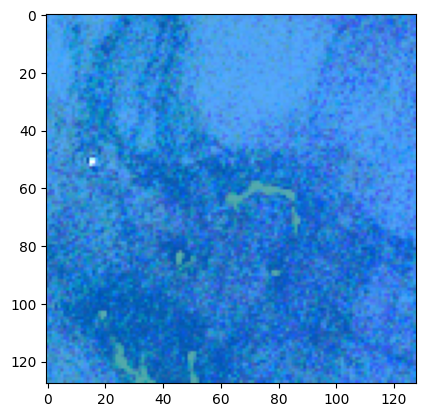

In [38]:
e = (x)
plt.imshow(equalize_hist(e.cpu().detach().numpy()[np.array([3,2,1])]).transpose(1,2,0))

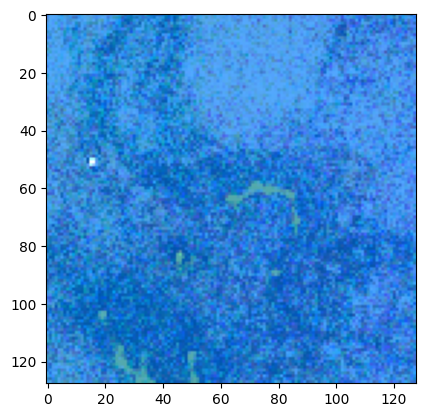

In [39]:
e = (x * m.unsqueeze(0))
plt.imshow(equalize_hist(e.cpu().detach().numpy()[np.array([3,2,1])]).transpose(1,2,0))

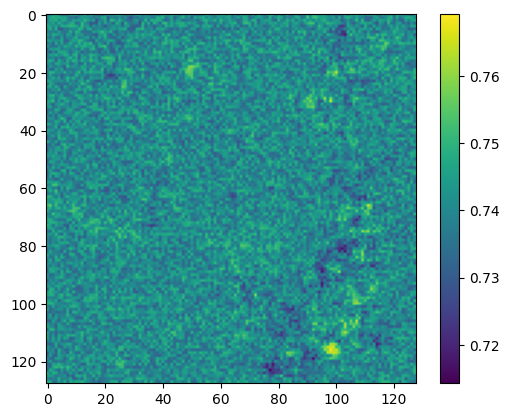

In [40]:
plt.imshow(torch.sigmoid(m.cpu().detach()))
plt.colorbar()

In [43]:
model(x.unsqueeze(0))

tensor([-3.4433], grad_fn=<SqueezeBackward1>)

In [248]:
m.max()

tensor(1.6388, grad_fn=<MaxBackward1>)

In [135]:
.shape

torch.Size([12, 128, 128])

In [217]:
logits_x == logits_e

tensor([True])

In [218]:
logits_x

tensor([-3.3301], grad_fn=<SqueezeBackward1>)